In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [4]:
torch.__version__

'0.3.1.post3'

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [6]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [7]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [8]:
batch_size = 100

In [9]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = MNIST

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [10]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [11]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data.numpy(), np.array(train_loader.dataset.train_labels), train_size=3000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((3000, 28, 28), (57000, 28, 28), (3000,), (57000,))

In [12]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.098716666666666661

In [13]:
np.max(train_dataset_labelled)

255

In [14]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(train_dataset_labelled).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(train_dataset_unlabelled).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [15]:
input_shape = [1, 28, 28]
output_size = 10

**WAE-WGAN**

In [16]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    #print(x_true.shape, x_distr.shape)
    n, D = x_true.shape
    eps = 1e-5
    x_distr = torch.clamp(x_distr.view(n, K, D), eps, 1-eps)
    x_true = x_true.view(n, 1, D)
    return -torch.sum(torch.log(x_distr) * x_true + torch.log(1 - x_distr) * (1 - x_true), dim=2)

In [17]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [18]:
class GeneratorConditioned(nn.Module):
    def __init__(self, input_shape, output_dim=512, noise_magnitude=0.0):
        super(type(self), self).__init__()
        #assert input_shape[1] == input_shape[2]
        self.noise_magnitude = noise_magnitude

        self.image_processor = nn.Sequential(
            ReshapeLayer(1, 28, 28), # [1 x 28 x 28]
            nn.Conv2d(1, 128, 4, padding=1, stride=2), # [128 x 14 x 14]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, padding=2, stride=2), # [256 x 8 x 8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, padding=1, stride=2), # [512 x 4 x 4]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 4, padding=1, stride=2), # [1024 x 2 x 2]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 2 * 2),
            nn.Linear(1024 * 2 * 2, output_dim) # [output_dim]
        )

    def forward(self, X, Z=None):
        if Z is None:
            Z = torch.normal(means=torch.zeros_like(X)) * self.noise_magnitude
        return self.image_processor(X + Z)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, hidden_count=4):
        super(type(self), self).__init__()

        self.layers = nn.ModuleList([
            ReshapeLayer(-1),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        ])
        for _ in range(hidden_count-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [20]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        #assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            ReshapeLayer(1, 28, 28), # [1 x 28 x 28]
            nn.Dropout(p=0.2),
            nn.Conv2d(1, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(5)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.softmax(self.output_layer(X), dim=-1)

In [21]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.cuda.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).cuda().scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [22]:
def sample_gumbel(input):
    noise = cuda_wrapper(torch.rand(input.size()))
    eps = 1e-20
    noise.add_(eps).log_().neg_()
    noise.add_(eps).log_().neg_()
    return Variable(noise)

def gumbel_softmax_sample(input, temperature=1, hard=False):
    noise = sample_gumbel(input)
    x = (input + noise) / temperature
    x = F.softmax(x, dim=-1)

    if hard == True:
        _, max_inx = torch.max(x, x.dim()-1)
        x_hard = cuda_wrapper(torch.FloatTensor(x.size())).zero_().scatter_(x.dim()-1, max_inx.data, 1.0)
        x2 = x.clone()
        tmp = Variable(x_hard-x2.data)
        tmp.detach_()

        x = tmp + x
        
    return x.view_as(input)

In [58]:
class WAE_WGAN_SemiSupervised(nn.Module):
    def __init__(self, input_shape, latent_dim, n_classes):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        
        self.proposal_generator = GeneratorConditioned(input_shape, output_dim=latent_dim)
        self.proposal_discriminator = Discriminator(latent_dim)
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 1024 * 7 * 7),
            ReshapeLayer(1024, 7, 7), # [1024 x 7 x 7]
            nn.ConvTranspose2d(1024, 512, 4, padding=1, stride=2), # [512 x 14 x 14]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, padding=1, stride=2), # [256 x 28 x 28]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 1, 1), # [1 x 28 x 28]
            #nn.Sigmoid()
        )

        self.classifier = ModelConvolutional(input_shape, n_classes)
        
    def prior_distr(self, n):
        mu = cuda_wrapper(Variable(torch.zeros(n, self.latent_dim)))
        sigma = cuda_wrapper(Variable(torch.ones(n, self.latent_dim)))
        return mu, sigma

    def sample_latent(self, X):
        return self.proposal_generator(X)

    def sample_prior(self, num_samples):
        return torch.normal(*self.prior_distr(num_samples))
    
    def classify(self, X):
        return self.classifier(X)

    def generative_distr(self, Z, Y_one_hot):
        return self.generative_network(torch.cat([Z, Y_one_hot], dim=-1))

    def batch_loss(self, X, Y_target=None,
                   return_reconstruction_loss=True, return_discriminator_loss=True, return_lipschitz_loss=True,
                   return_reconstruction_classification_loss=True):
        n = X.shape[0]
        
        if Y_target is None:
            if return_reconstruction_loss:
                Y_distr = self.classify(X)
                Y_one_hot = gumbel_softmax_sample(Y_distr)
            classification_loss = None
            classification_accuracy = None
        else:
            Y_distr = self.classify(X)
            Y_one_hot = to_one_hot(Y_target, n_dims=self.n_classes)
            classification_loss = F.nll_loss(torch.log(Y_distr), Y_target)
            classification_accuracy = torch.mean((torch.max(Y_distr, dim=-1)[1] == Y_target).float())
        
        Z = self.sample_latent(X)
        Z_prior = self.sample_prior(n)
        if return_reconstruction_loss:
            X_rec = self.generative_distr(Z, Y_one_hot)
            reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
            #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
            #reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
            if return_reconstruction_classification_loss:
                Y_distr = self.classify(X_rec)
                reconstruction_classification_loss = F.binary_cross_entropy(Y_distr, Y_one_hot)
            else:
                reconstruction_classification_loss = None
        else:
            reconstruction_loss = None
            reconstruction_classification_loss = None
        if return_discriminator_loss:
            discriminator_loss = torch.mean(self.proposal_discriminator(Z_prior) - self.proposal_discriminator(Z))
        else:
            discriminator_loss = None
        if return_lipschitz_loss:
            eps = cuda_wrapper(torch.rand(n, 1))
            Z_hat = Variable(Z_prior.data * eps + Z.data * (1 - eps), requires_grad=True)
            value_hat = self.proposal_discriminator(Z_hat)
            value_hat_grad_sqr_norm = torch.sum(
                autograd.grad([torch.sum(value_hat)], [Z_hat], create_graph=True)[0].view(n, -1) ** 2, dim=-1
            )
            lipschitz_loss = torch.mean((value_hat_grad_sqr_norm - 1) ** 2)
        else:
            lipschitz_loss = None
        return reconstruction_loss, discriminator_loss, lipschitz_loss, \
               classification_loss, classification_accuracy, reconstruction_classification_loss
        
    def sample_classification_loss(self, batch_size):
        Z = self.sample_prior(batch_size)
        Y = Variable(cuda_wrapper(torch.LongTensor(batch_size)).random_(to=self.n_classes))
        Y_one_hot = to_one_hot(Y, n_dims=self.n_classes)
        X_rec = self.generative_distr(Z, Y_one_hot)
        Y_distr = self.classify(X_rec)
        classification_loss = F.binary_cross_entropy(Y_distr, Y_one_hot)
        classification_accuracy = torch.mean((torch.max(Y_distr, dim=-1)[1] == torch.max(Y_one_hot, dim=-1)[1]).float())
        return classification_loss, classification_accuracy

    def generate_samples(self, Y_target):
        return self.generative_distr(self.sample_prior(Y_target.size(0)), to_one_hot(Y_target, n_dims=self.n_classes))

Epoch 1 of 100 took 26.63s;
unsupervised train reconstruction loss: 73.12; supervised train reconstruction loss: 47.61; test reconstruction loss: 46.66
unsupervised train discriminator loss: -0.32; supervised train discriminator loss: -0.22; test discriminator loss: 0.00
unsupervised train lipschitz loss: 0.15; supervised train lipschitz loss: 0.07; test lipschitz loss: 0.05
train classifier loss: 1.62; test classifier loss: 1.11
sample classification loss: 0.33; supervised train reconstruction classification loss: 0.32
train classifier accuracy: 59.03; test classifier accuracy: 71.57; sample classification accuracy: 10.00

Epoch 2 of 100 took 26.65s;
unsupervised train reconstruction loss: 45.26; supervised train reconstruction loss: 42.82; test reconstruction loss: 42.15
unsupervised train discriminator loss: 0.12; supervised train discriminator loss: 0.29; test discriminator loss: 0.41
unsupervised train lipschitz loss: 0.15; supervised train lipschitz loss: 0.06; test lipschitz los

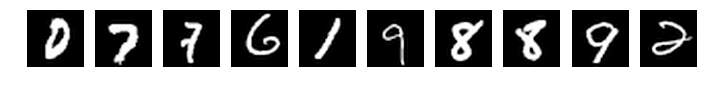

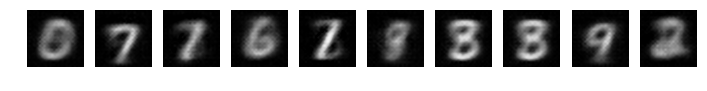

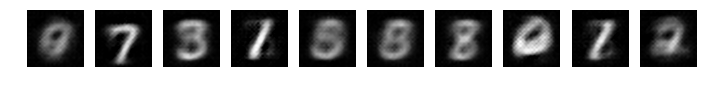

Epoch 6 of 100 took 26.66s;
unsupervised train reconstruction loss: 43.67; supervised train reconstruction loss: 39.88; test reconstruction loss: 38.44
unsupervised train discriminator loss: 0.19; supervised train discriminator loss: -0.81; test discriminator loss: -0.56
unsupervised train lipschitz loss: 0.11; supervised train lipschitz loss: 0.15; test lipschitz loss: 0.06
train classifier loss: 0.19; test classifier loss: 0.18
sample classification loss: 0.42; supervised train reconstruction classification loss: 0.10
train classifier accuracy: 95.30; test classifier accuracy: 95.49; sample classification accuracy: 32.00

Epoch 7 of 100 took 26.73s;
unsupervised train reconstruction loss: 41.55; supervised train reconstruction loss: 37.71; test reconstruction loss: 38.31
unsupervised train discriminator loss: 0.16; supervised train discriminator loss: 0.00; test discriminator loss: 0.12
unsupervised train lipschitz loss: 0.10; supervised train lipschitz loss: 0.05; test lipschitz los

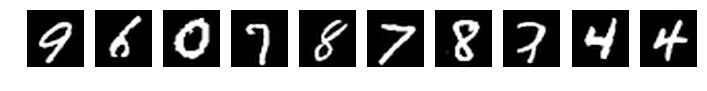

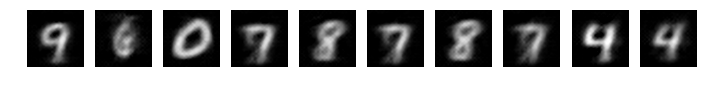

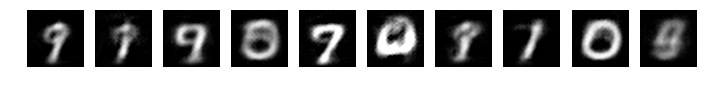

Epoch 11 of 100 took 26.68s;
unsupervised train reconstruction loss: 40.99; supervised train reconstruction loss: 38.88; test reconstruction loss: 39.44
unsupervised train discriminator loss: 0.28; supervised train discriminator loss: 0.17; test discriminator loss: -0.92
unsupervised train lipschitz loss: 0.10; supervised train lipschitz loss: 0.12; test lipschitz loss: 0.08
train classifier loss: 0.14; test classifier loss: 0.13
sample classification loss: 0.43; supervised train reconstruction classification loss: 0.09
train classifier accuracy: 95.80; test classifier accuracy: 96.24; sample classification accuracy: 37.00

Epoch 12 of 100 took 26.72s;
unsupervised train reconstruction loss: 40.06; supervised train reconstruction loss: 37.66; test reconstruction loss: 36.48
unsupervised train discriminator loss: 0.15; supervised train discriminator loss: -0.33; test discriminator loss: -0.25
unsupervised train lipschitz loss: 0.09; supervised train lipschitz loss: 0.12; test lipschitz 

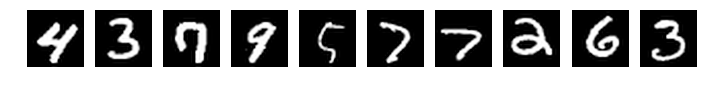

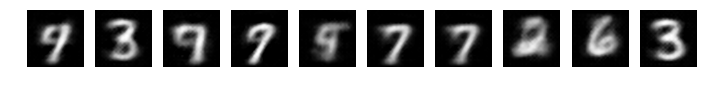

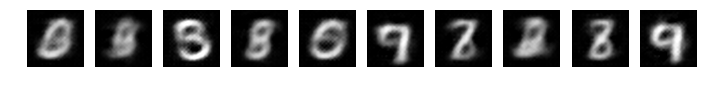

Epoch 16 of 100 took 26.62s;
unsupervised train reconstruction loss: 39.35; supervised train reconstruction loss: 35.31; test reconstruction loss: 34.76
unsupervised train discriminator loss: 0.20; supervised train discriminator loss: -0.14; test discriminator loss: -0.14
unsupervised train lipschitz loss: 0.13; supervised train lipschitz loss: 0.08; test lipschitz loss: 0.06
train classifier loss: 0.14; test classifier loss: 0.09
sample classification loss: 0.49; supervised train reconstruction classification loss: 0.04
train classifier accuracy: 95.83; test classifier accuracy: 97.43; sample classification accuracy: 34.00

Epoch 17 of 100 took 26.72s;
unsupervised train reconstruction loss: 38.64; supervised train reconstruction loss: 36.31; test reconstruction loss: 34.06
unsupervised train discriminator loss: 0.16; supervised train discriminator loss: -0.02; test discriminator loss: -0.05
unsupervised train lipschitz loss: 0.08; supervised train lipschitz loss: 0.13; test lipschitz

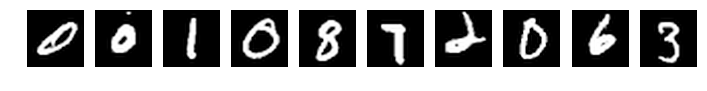

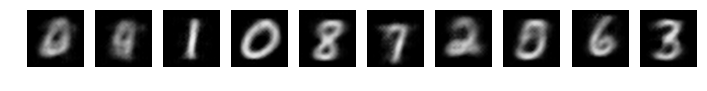

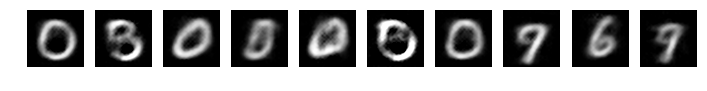

Epoch 21 of 100 took 26.70s;
unsupervised train reconstruction loss: 38.30; supervised train reconstruction loss: 35.08; test reconstruction loss: 36.35
unsupervised train discriminator loss: 0.33; supervised train discriminator loss: 0.60; test discriminator loss: 0.50
unsupervised train lipschitz loss: 0.06; supervised train lipschitz loss: 0.07; test lipschitz loss: 0.07
train classifier loss: 0.11; test classifier loss: 0.07
sample classification loss: 0.47; supervised train reconstruction classification loss: 0.02
train classifier accuracy: 96.83; test classifier accuracy: 97.97; sample classification accuracy: 44.00

Epoch 22 of 100 took 26.78s;
unsupervised train reconstruction loss: 38.36; supervised train reconstruction loss: 34.35; test reconstruction loss: 34.68
unsupervised train discriminator loss: 0.30; supervised train discriminator loss: 0.18; test discriminator loss: 0.06
unsupervised train lipschitz loss: 0.07; supervised train lipschitz loss: 0.05; test lipschitz los

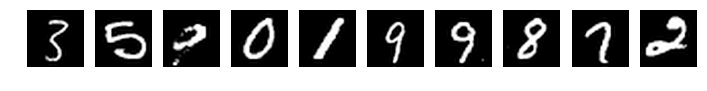

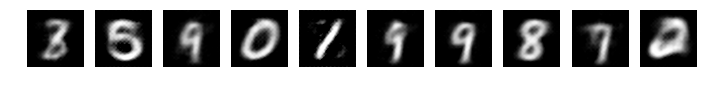

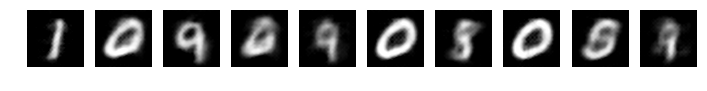

Epoch 26 of 100 took 26.64s;
unsupervised train reconstruction loss: 37.26; supervised train reconstruction loss: 32.70; test reconstruction loss: 33.63
unsupervised train discriminator loss: 0.14; supervised train discriminator loss: 0.39; test discriminator loss: 0.25
unsupervised train lipschitz loss: 0.08; supervised train lipschitz loss: 0.12; test lipschitz loss: 0.08
train classifier loss: 0.10; test classifier loss: 0.06
sample classification loss: 0.72; supervised train reconstruction classification loss: 0.05
train classifier accuracy: 96.60; test classifier accuracy: 97.92; sample classification accuracy: 19.00

Epoch 27 of 100 took 26.72s;
unsupervised train reconstruction loss: 37.04; supervised train reconstruction loss: 35.32; test reconstruction loss: 38.40
unsupervised train discriminator loss: 0.09; supervised train discriminator loss: 0.40; test discriminator loss: 0.49
unsupervised train lipschitz loss: 0.10; supervised train lipschitz loss: 0.05; test lipschitz los

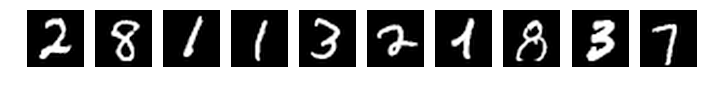

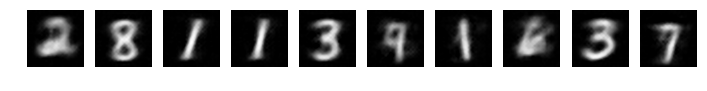

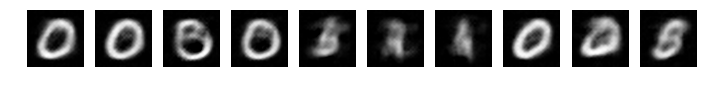

Epoch 31 of 100 took 26.62s;
unsupervised train reconstruction loss: 35.95; supervised train reconstruction loss: 33.62; test reconstruction loss: 32.42
unsupervised train discriminator loss: 0.15; supervised train discriminator loss: 0.15; test discriminator loss: 0.16
unsupervised train lipschitz loss: 0.03; supervised train lipschitz loss: 0.02; test lipschitz loss: 0.02
train classifier loss: 0.09; test classifier loss: 0.06
sample classification loss: 0.59; supervised train reconstruction classification loss: 0.05
train classifier accuracy: 97.27; test classifier accuracy: 98.07; sample classification accuracy: 33.00

Epoch 32 of 100 took 26.68s;
unsupervised train reconstruction loss: 35.63; supervised train reconstruction loss: 32.82; test reconstruction loss: 32.42
unsupervised train discriminator loss: 0.17; supervised train discriminator loss: 0.19; test discriminator loss: 0.16
unsupervised train lipschitz loss: 0.03; supervised train lipschitz loss: 0.02; test lipschitz los

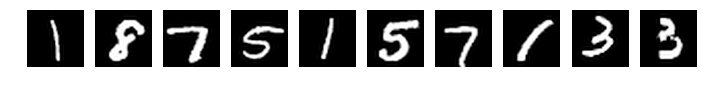

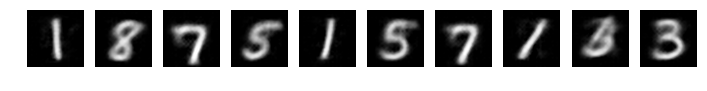

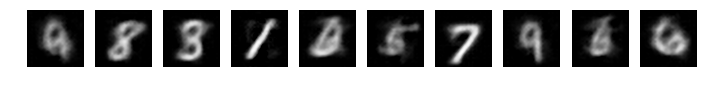

Epoch 36 of 100 took 26.70s;
unsupervised train reconstruction loss: 35.08; supervised train reconstruction loss: 32.84; test reconstruction loss: 31.93
unsupervised train discriminator loss: 0.21; supervised train discriminator loss: 0.37; test discriminator loss: 0.39
unsupervised train lipschitz loss: 0.04; supervised train lipschitz loss: 0.07; test lipschitz loss: 0.07
train classifier loss: 0.06; test classifier loss: 0.07
sample classification loss: 0.65; supervised train reconstruction classification loss: 0.03
train classifier accuracy: 98.33; test classifier accuracy: 97.94; sample classification accuracy: 34.00

Epoch 37 of 100 took 26.73s;
unsupervised train reconstruction loss: 35.47; supervised train reconstruction loss: 31.08; test reconstruction loss: 32.12
unsupervised train discriminator loss: 0.12; supervised train discriminator loss: 0.21; test discriminator loss: 0.26
unsupervised train lipschitz loss: 0.08; supervised train lipschitz loss: 0.04; test lipschitz los

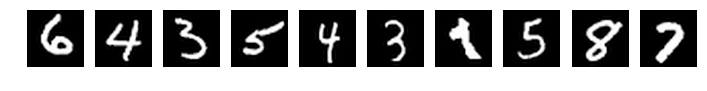

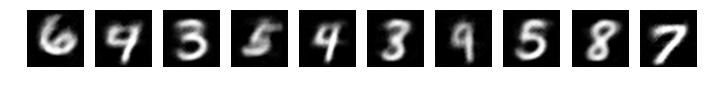

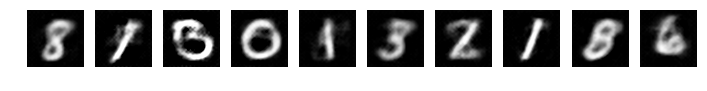

Epoch 41 of 100 took 26.66s;
unsupervised train reconstruction loss: 34.36; supervised train reconstruction loss: 31.46; test reconstruction loss: 31.47
unsupervised train discriminator loss: 0.19; supervised train discriminator loss: 0.34; test discriminator loss: 0.33
unsupervised train lipschitz loss: 0.02; supervised train lipschitz loss: 0.02; test lipschitz loss: 0.03
train classifier loss: 0.06; test classifier loss: 0.07
sample classification loss: 0.77; supervised train reconstruction classification loss: 0.03
train classifier accuracy: 98.03; test classifier accuracy: 97.71; sample classification accuracy: 27.00

Epoch 42 of 100 took 26.68s;
unsupervised train reconstruction loss: 33.98; supervised train reconstruction loss: 31.65; test reconstruction loss: 31.77
unsupervised train discriminator loss: 0.16; supervised train discriminator loss: 0.27; test discriminator loss: 0.20
unsupervised train lipschitz loss: 0.02; supervised train lipschitz loss: 0.02; test lipschitz los

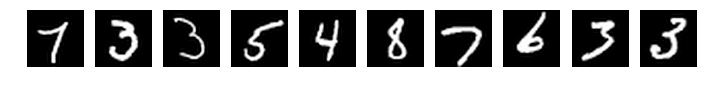

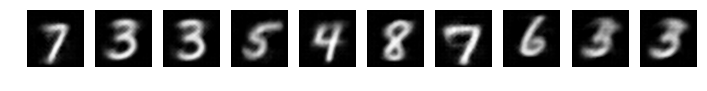

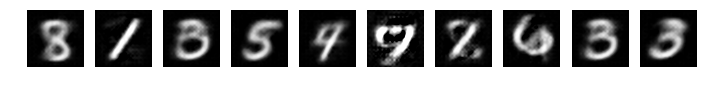

Epoch 46 of 100 took 26.73s;
unsupervised train reconstruction loss: 34.67; supervised train reconstruction loss: 31.26; test reconstruction loss: 31.74
unsupervised train discriminator loss: 0.15; supervised train discriminator loss: 0.20; test discriminator loss: 0.24
unsupervised train lipschitz loss: 0.02; supervised train lipschitz loss: 0.02; test lipschitz loss: 0.02
train classifier loss: 0.06; test classifier loss: 0.07
sample classification loss: 0.88; supervised train reconstruction classification loss: 0.04
train classifier accuracy: 98.13; test classifier accuracy: 97.78; sample classification accuracy: 29.00

Epoch 47 of 100 took 26.76s;
unsupervised train reconstruction loss: 34.29; supervised train reconstruction loss: 31.82; test reconstruction loss: 31.57
unsupervised train discriminator loss: 0.24; supervised train discriminator loss: 0.46; test discriminator loss: 0.47
unsupervised train lipschitz loss: 0.03; supervised train lipschitz loss: 0.04; test lipschitz los

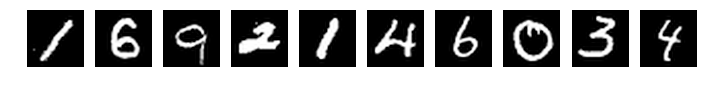

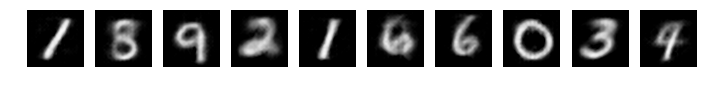

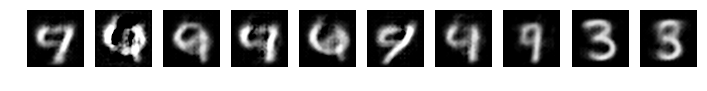

Epoch 51 of 100 took 26.67s;
unsupervised train reconstruction loss: 33.67; supervised train reconstruction loss: 31.18; test reconstruction loss: 30.99
unsupervised train discriminator loss: 0.14; supervised train discriminator loss: -0.09; test discriminator loss: -0.07
unsupervised train lipschitz loss: 0.03; supervised train lipschitz loss: 0.02; test lipschitz loss: 0.03
train classifier loss: 0.06; test classifier loss: 0.06
sample classification loss: 0.88; supervised train reconstruction classification loss: 0.06
train classifier accuracy: 98.00; test classifier accuracy: 98.05; sample classification accuracy: 29.00

Epoch 52 of 100 took 26.85s;
unsupervised train reconstruction loss: 33.63; supervised train reconstruction loss: 31.12; test reconstruction loss: 31.68
unsupervised train discriminator loss: 0.16; supervised train discriminator loss: 0.28; test discriminator loss: 0.11
unsupervised train lipschitz loss: 0.03; supervised train lipschitz loss: 0.05; test lipschitz l

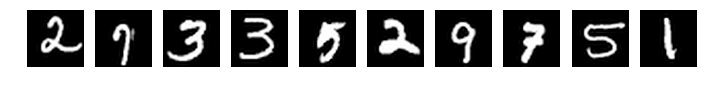

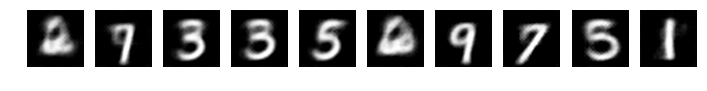

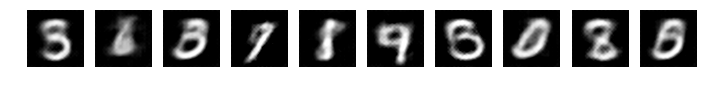

Epoch 56 of 100 took 26.74s;
unsupervised train reconstruction loss: 33.73; supervised train reconstruction loss: 29.71; test reconstruction loss: 30.51
unsupervised train discriminator loss: 0.11; supervised train discriminator loss: 0.21; test discriminator loss: 0.27
unsupervised train lipschitz loss: 0.04; supervised train lipschitz loss: 0.02; test lipschitz loss: 0.02
train classifier loss: 0.05; test classifier loss: 0.05
sample classification loss: 0.98; supervised train reconstruction classification loss: 0.04
train classifier accuracy: 98.27; test classifier accuracy: 98.27; sample classification accuracy: 26.00

Epoch 57 of 100 took 26.78s;
unsupervised train reconstruction loss: 34.77; supervised train reconstruction loss: 30.69; test reconstruction loss: 30.52
unsupervised train discriminator loss: 0.10; supervised train discriminator loss: 0.11; test discriminator loss: 0.07
unsupervised train lipschitz loss: 0.04; supervised train lipschitz loss: 0.03; test lipschitz los

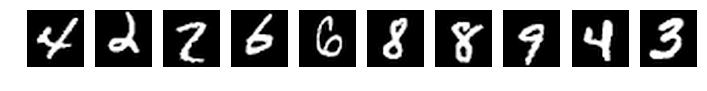

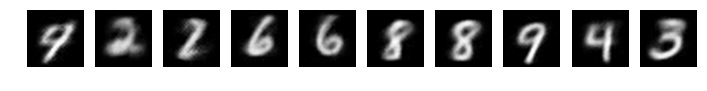

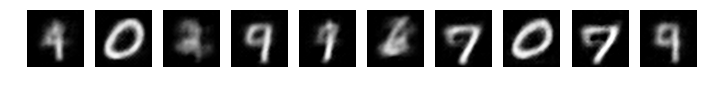

Epoch 61 of 100 took 26.68s;
unsupervised train reconstruction loss: 32.62; supervised train reconstruction loss: 30.12; test reconstruction loss: 30.38
unsupervised train discriminator loss: 0.13; supervised train discriminator loss: 0.18; test discriminator loss: 0.19
unsupervised train lipschitz loss: 0.04; supervised train lipschitz loss: 0.08; test lipschitz loss: 0.06
train classifier loss: 0.07; test classifier loss: 0.07
sample classification loss: 0.99; supervised train reconstruction classification loss: 0.06
train classifier accuracy: 98.10; test classifier accuracy: 97.87; sample classification accuracy: 27.00

Epoch 62 of 100 took 26.77s;
unsupervised train reconstruction loss: 32.44; supervised train reconstruction loss: 30.14; test reconstruction loss: 31.68
unsupervised train discriminator loss: 0.10; supervised train discriminator loss: 0.24; test discriminator loss: 0.26
unsupervised train lipschitz loss: 0.05; supervised train lipschitz loss: 0.04; test lipschitz los

In [ ]:
latent_dim = 2

num_epochs = 100
save_every = 100

name_prefix = 'wae_gan_m2_results/'

#try:
if True:
    #vae = cuda_wrapper(VAE(latent_dim, input_shape))
    #vae.load_state_dict(torch.load(name_prefix + 'vae.pt'))
    #print("Found pretrained VAE")
#except:
    #print("Didn't found pretrained VAE; training...")
    
    wae = cuda_wrapper(WAE_WGAN_SemiSupervised(input_shape, latent_dim, output_size))
    
    optimizer = optim.Adam(
        list(wae.proposal_generator.parameters()) + list(wae.generative_network.parameters()), 
        lr=5e-4, betas=(0.5, 0.999)
    )
    optimizer_discriminator = optim.Adam(wae.proposal_discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
    optimizer_supervised_labelled = optim.Adam(wae.classifier.parameters(), lr=5e-4, betas=(0.5, 0.999))
    optimizer_supervised_unlabelled = optim.Adam(wae.classifier.parameters(), lr=5e-4, betas=(0.5, 0.999))
    optimizer_sample_classification = optim.Adam(wae.generative_network.parameters(), lr=5e-4, betas=(0.5, 0.999))

    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )
    scheduler_discriminator = optim.lr_scheduler.LambdaLR(
        optimizer_discriminator, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )

    for epoch in range(num_epochs):
        start_time = time()
    
        #scheduler.step()
        #scheduler_discriminator.step()
        
        regularization_factor = 10
        lipschitz_contraint_factor = 2
        update_generator_every = 10
        
        wae.train()
        
        cum_loss_sample_classification = 0
        cum_acc_sample_classification = 0
        batch_count = 0
        
        for _ in range(len(train_loader.dataset.train_labels) // batch_size // 2 * 0 + 1):
            loss_sample_classification, acc_sample_classification = wae.sample_classification_loss(batch_size)
            cum_loss_sample_classification += loss_sample_classification.data[0]
            cum_acc_sample_classification += acc_sample_classification.data[0]
            
            optimizer_sample_classification.zero_grad()
            loss_sample_classification.backward()
            optimizer_sample_classification.step()
            batch_count += 1
            
        mean_loss_sample_classification = cum_loss_sample_classification / batch_count
        mean_acc_sample_classification = cum_acc_sample_classification / batch_count
        
        cum_loss_reconstruction = 0
        cum_loss_discriminator = 0
        cum_loss_lipschitz = 0
        batch_count = 0
        
        for X_batch, _ in train_loader_unlabelled:
            X_batch = cuda_wrapper(Variable(X_batch.view(-1, *input_shape)))

            do_discriminator_update = (
                epoch * len(train_loader.dataset.train_labels) // X_batch.shape[0] + batch_count
            ) % update_generator_every > 0
        
            if do_discriminator_update:
                _, loss_discriminator, loss_lipschitz, _, _, _ = wae.batch_loss(
                    X_batch, return_reconstruction_loss=False
                )
                cum_loss_discriminator += loss_discriminator.data[0]
                cum_loss_lipschitz += loss_lipschitz.data[0]
                
                optimizer_discriminator.zero_grad()
                (loss_discriminator + loss_lipschitz * lipschitz_contraint_factor).backward()
                #torch.nn.utils.clip_grad_norm(wae.proposal_discriminator.parameters(), 2)
                optimizer_discriminator.step()
            else:
                loss_reconstruction, loss_discriminator, _, _, _, _ = wae.batch_loss(
                    X_batch, return_lipschitz_loss=False, return_reconstruction_classification_loss=False
                )
                cum_loss_reconstruction += loss_reconstruction.data[0]
                cum_loss_discriminator += loss_discriminator.data[0]
                
                optimizer.zero_grad()
                optimizer_supervised_unlabelled.zero_grad()
                (loss_reconstruction - loss_discriminator * regularization_factor).backward()
                #torch.nn.utils.clip_grad_norm(wae.proposal_generator.parameters(), 1)
                #torch.nn.utils.clip_grad_norm(wae.generative_network.parameters(), 1)
                #torch.nn.utils.clip_grad_norm(wae.classifier.parameters(), 1)
                optimizer.step()
                optimizer_supervised_unlabelled.step()
            batch_count += 1
    
        mean_train_loss_reconstruction_unsupervised = cum_loss_reconstruction / (batch_count / update_generator_every)
        mean_train_loss_discriminator_unsupervised = cum_loss_discriminator / batch_count
        mean_train_loss_lipschitz_unsupervised = cum_loss_lipschitz / \
                                                 ((update_generator_every - 1) * batch_count / update_generator_every)

        cum_loss_reconstruction = 0
        cum_loss_discriminator = 0
        cum_loss_lipschitz = 0
        cum_loss_classifier = 0
        cum_acc_classifier = 0
        cum_loss_reconstruction_classification = 0
        batch_count = 0
        
        for X_batch, y_batch in train_loader_labelled:
            X_batch, y_batch = cuda_wrapper(Variable(X_batch.view(-1, *input_shape))), cuda_wrapper(Variable(y_batch))

            do_discriminator_update = (
                epoch * len(train_loader.dataset.train_labels) // X_batch.shape[0] + batch_count
            ) % update_generator_every > 0
        
            if do_discriminator_update:
                _, loss_discriminator, loss_lipschitz, loss_classifier, acc_classifier, _ = wae.batch_loss(
                    X_batch, y_batch, return_reconstruction_loss=False
                )
                cum_loss_discriminator += loss_discriminator.data[0]
                cum_loss_lipschitz += loss_lipschitz.data[0]
                cum_loss_classifier += loss_classifier.data[0]
                cum_acc_classifier += acc_classifier.data[0]
                
                optimizer_discriminator.zero_grad()
                optimizer_supervised_labelled.zero_grad()
                (loss_discriminator + loss_lipschitz * lipschitz_contraint_factor).backward()
                loss_classifier.backward()
                #torch.nn.utils.clip_grad_norm(wae.proposal_discriminator.parameters(), 1)
                #torch.nn.utils.clip_grad_norm(wae.classifier.parameters(), 1)
                optimizer_discriminator.step()
                optimizer_supervised_labelled.step()
            else:
                loss_reconstruction, loss_discriminator, _, loss_classifier, acc_classifier, \
                loss_reconstruction_classification = wae.batch_loss(
                    X_batch, y_batch, return_lipschitz_loss=False
                )
                cum_loss_reconstruction += loss_reconstruction.data[0]
                cum_loss_discriminator += loss_discriminator.data[0]
                cum_loss_classifier += loss_classifier.data[0]
                cum_acc_classifier += acc_classifier.data[0]
                cum_loss_reconstruction_classification += loss_reconstruction_classification.data[0]
                
                optimizer.zero_grad()
                optimizer_supervised_labelled.zero_grad()
                #optimizer_sample_classification.zero_grad()
                (loss_reconstruction - loss_discriminator * regularization_factor).backward(retain_graph=True)
                loss_classifier.backward()
                #loss_reconstruction_classification.backward()
                #torch.nn.utils.clip_grad_norm(wae.proposal_generator.parameters(), 1)
                #torch.nn.utils.clip_grad_norm(wae.generative_network.parameters(), 1)
                #torch.nn.utils.clip_grad_norm(wae.classifier.parameters(), 1)
                optimizer.step()
                optimizer_supervised_labelled.step()
                #optimizer_sample_classification.step()
            batch_count += 1
    
        mean_train_loss_reconstruction_supervised = cum_loss_reconstruction / (batch_count / update_generator_every)
        mean_train_loss_discriminator_supervised = cum_loss_discriminator / batch_count
        mean_train_loss_lipschitz_supervised = cum_loss_lipschitz / \
                                               ((update_generator_every - 1) * batch_count / update_generator_every)
        mean_train_loss_classifier = cum_loss_classifier / batch_count
        mean_train_acc_classifier = cum_acc_classifier / batch_count
        mean_train_loss_reconstruction_classification = cum_loss_reconstruction_classification / \
                                                        (batch_count / update_generator_every)

        cum_loss_reconstruction = 0
        cum_loss_discriminator = 0
        cum_loss_lipschitz = 0
        cum_loss_classifier = 0
        cum_acc_classifier = 0
        batch_count = 0
        
        wae.eval()
        
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = cuda_wrapper(Variable(X_batch.view(-1, *input_shape))), cuda_wrapper(Variable(y_batch))

            loss_reconstruction, loss_discriminator, loss_lipschitz, loss_classifier, acc_classifier, _ = wae.batch_loss(
                X_batch, y_batch, return_reconstruction_classification_loss=False
            )
            cum_loss_reconstruction += loss_reconstruction.data[0]
            cum_loss_discriminator += loss_discriminator.data[0]
            cum_loss_lipschitz += loss_lipschitz.data[0]
            cum_loss_classifier += loss_classifier.data[0]
            cum_acc_classifier += acc_classifier.data[0]
        
            batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_test_loss_discriminator = cum_loss_discriminator / batch_count
        mean_test_loss_lipschitz = cum_loss_lipschitz / batch_count
        mean_test_loss_classifier = cum_loss_classifier / batch_count
        mean_test_acc_classifier = cum_acc_classifier / batch_count


        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print(('unsupervised train reconstruction loss: {:.2f}; supervised train reconstruction loss: {:.2f}; ' +
              'test reconstruction loss: {:.2f}').format(
            mean_train_loss_reconstruction_unsupervised, mean_train_loss_reconstruction_supervised, 
            mean_test_loss_reconstruction
        ))
        print(('unsupervised train discriminator loss: {:.2f}; supervised train discriminator loss: {:.2f}; ' +
              'test discriminator loss: {:.2f}').format(
            mean_train_loss_discriminator_unsupervised, mean_train_loss_discriminator_supervised, 
            mean_test_loss_discriminator
        ))
        print(('unsupervised train lipschitz loss: {:.2f}; supervised train lipschitz loss: {:.2f}; ' +
              'test lipschitz loss: {:.2f}').format(
            mean_train_loss_lipschitz_unsupervised, mean_train_loss_lipschitz_supervised, mean_test_loss_lipschitz
        ))
        print('train classifier loss: {:.2f}; test classifier loss: {:.2f}'.format(
            mean_train_loss_classifier, mean_test_loss_classifier
        ))
        print('sample classification loss: {:.2f}; supervised train reconstruction classification loss: {:.2f}'.format(
            mean_loss_sample_classification, mean_train_loss_reconstruction_classification
        ))
        print(('train classifier accuracy: {:.2f}; test classifier accuracy: {:.2f}; ' +
              'sample classification accuracy: {:.2f}').format(
            mean_train_acc_classifier*100, mean_test_acc_classifier*100, mean_acc_sample_classification*100
        ))
        print()
        
        if (epoch+1) % 5 == 0:
            X_batch, y_batch = next(iter(train_loader))
            X_batch, y_batch = cuda_wrapper(Variable(X_batch[:10])), cuda_wrapper(Variable(y_batch[:10]))
            show_images(X_batch)
            plt.show()
            show_images(
                wae.generative_distr(
                    wae.proposal_generator(X_batch), to_one_hot(y_batch, n_dims=output_size)
                )
            )
            plt.show()
            show_images(wae.generate_samples(y_batch))
            plt.show()
        
        #if (epoch+1) % save_every == 0:
        #    torch.save(wae.state_dict(), name_prefix + 'wae_gan_m2.pt')


In [25]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].view(28, 28).cpu().numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

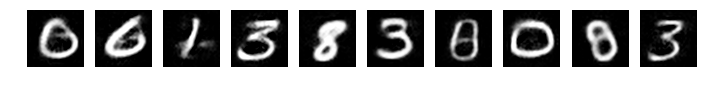

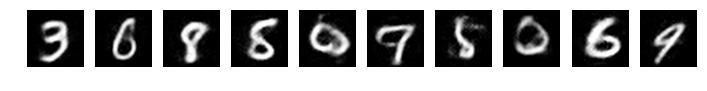

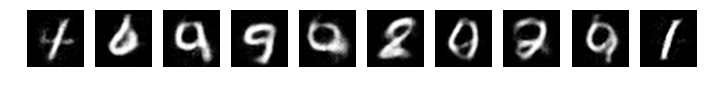

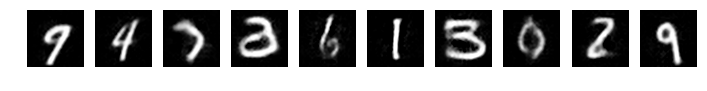

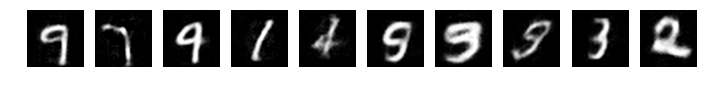

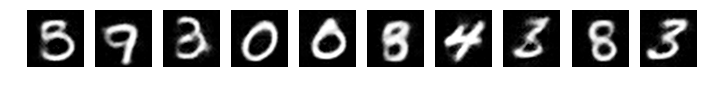

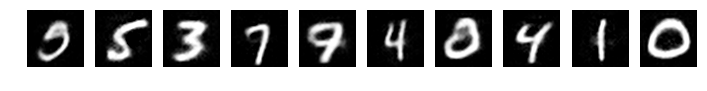

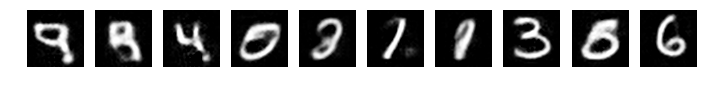

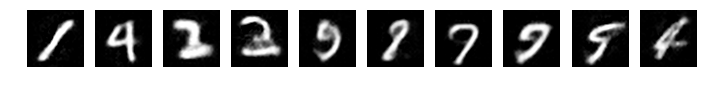

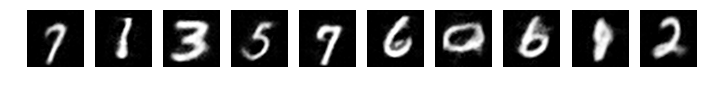

In [67]:
for label in range(10):
    show_images(wae.generate_samples(cuda_wrapper(Variable(torch.arange(output_size)))))
    plt.show()

**Tangent prop**

In [24]:
def constrain_loss_function(model, vae, batch_gen=None, reparam_invariant=True, use_all_classes=False):
    latent_dim = vae.latent_size
    
    if reparam_invariant:
        if batch_gen is None:
            z_gen = cuda_wrapper(
                Variable(torch.normal(std=torch.ones(batch_size, latent_dim)))
            ) # [batch_size x latent_dim]
            X_gen = Variable(vae.generative_distr(z_gen).data, requires_grad=True) # [batch_size x C x H x W]
        else:
            X_gen, _ = next(batch_gen)
            X_gen = cuda_wrapper(Variable(X_gen, requires_grad=True))
        z_inferred = vae.sample_latent(vae.proposal_distr(X_gen)) # [batch_size x latent_dim]
    else:
        if batch_gen is None:
            z_inferred = cuda_wrapper(
                Variable(torch.normal(std=torch.ones(batch_size, latent_dim)), requires_grad=True)
            ) # [batch_size x latent_dim]
        else:
            X, _ = next(batch_gen)
            X = cuda_wrapper(Variable(X))
            mu_inferred, sigma_inferred = vae.proposal_distr(X)
            z_inferred = cuda_wrapper(
                Variable(torch.normal(means=mu_inferred.data, std=sigma_inferred.data), requires_grad=True)
            ) # [batch_size x latent_dim]
    X_inferred = vae.generative_distr(z_inferred) # [batch_size x C x H x W]
    model_output = model(X_inferred) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [25]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [48]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [66]:
num_epochs = 100
save_every = 50

modes = ['tangent_prop_reparam_invariant_stochastic_eta=' + str(eta) for eta in [0, 1e-3, 1e-2, 1e-1]]

loss_function = nn.NLLLoss()

for mode in modes[1:]:
    mode_name = mode + '_labelled=4000_epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    model = cuda_wrapper(ModelConvolutional(input_shape, output_size))
    optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
    #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
    for epoch in range(num_epochs):
        start_time = time()
    
        #scheduler.step()
    
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_loss_full = 0
        cum_acc = 0
        batch_count = 0

        model.train()
        for X, y in train_loader_labelled:
            X, y = cuda_wrapper(Variable(X)), cuda_wrapper(Variable(y))
            prediction = model(X)
            loss_data = loss_function(prediction, y)
            cum_loss_data += loss_data.data[0]
        
            #X_random = cuda_wrapper(Variable(next(random_input_gen), requires_grad=True))
            #loss_constrain = constrain_loss_function(model(X_random), X_random)
            if mode == 'no_reg':
                loss_constrain = cuda_wrapper(Variable(torch.zeros(1)))
            elif mode == 'tangent_prop':
                loss_constrain = constrain_loss_function(model, vae, reparam_invariant=False, use_all_classes=True)
            elif mode.startswith('tangent_prop_reparam_invariant_stochastic'):
                loss_constrain = constrain_loss_function(model, vae, reparam_invariant=True, use_all_classes=False)
            else:
                raise NotImplementedError
            cum_loss_constrain += loss_constrain.data[0]
        
            loss_full = loss_data + eta * loss_constrain
            cum_loss_full += loss_full.data[0]
            
            acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
            cum_acc += acc.data[0]
        
            optimizer.zero_grad()
            loss_full.backward()
            optimizer.step()
            batch_count += 1
            
        mean_train_loss_data = cum_loss_data / batch_count
        mean_train_loss_constrain = cum_loss_constrain / batch_count
        mean_train_loss_full = cum_loss_full / batch_count
        mean_train_acc = cum_acc / batch_count

        train_losses[mode].append(mean_train_loss_data)
        train_accs[mode].append(mean_train_acc)
        
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_acc = 0
        batch_count = 0

        model.eval()
        for X, y in test_loader:
            X, y = cuda_wrapper(Variable(X)), cuda_wrapper(Variable(y))
            prediction = model(X)
            loss_data = loss_function(prediction, y)
            cum_loss_data += loss_data.data[0]
        
            #if mode == 'no_reg':
            #    loss_constrain = cuda_wrapper(Variable(torch.zeros(1)))
            #elif mode == 'tangent_prop':
            #    loss_constrain = constrain_loss_function(model, vae, reparam_invariant=False, use_all_classes=True)
            #elif mode == 'tangent_prop_reparam_invariant_stochastic':
            #    loss_constrain = constrain_loss_function(model, vae, reparam_invariant=True, use_all_classes=False)
            #else:
            #    raise NotImplementedError
            #cum_loss_constrain += loss_constrain.data[0]
        
            acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
            cum_acc += acc.data[0]
        
            batch_count += 1
            
        mean_test_loss_data = cum_loss_data / batch_count
        mean_test_loss_constrain = cum_loss_constrain / batch_count
        mean_test_acc = cum_acc / batch_count

        test_losses[mode].append(mean_test_loss_data)
        test_accs[mode].append(mean_test_acc)
        
        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
            )
        )
        print('train acc: {:.2f}'.format(mean_train_acc))
        print('test loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}'.format(
                mean_test_loss_data, mean_test_loss_constrain
            )
        )
        print('test acc: {:.2f}'.format(mean_test_acc))
        print()
        
        if (epoch+1) % save_every == 0:
            with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                pickle.dump(np.array(train_losses[mode]), f)
            with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                pickle.dump(np.array(test_losses[mode]), f)
            with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                pickle.dump(np.array(train_accs[mode]), f)
            with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                pickle.dump(np.array(test_accs[mode]), f)

            torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')



Mode: tangent_prop_reparam_invariant_stochastic_eta=0.001
tangent_prop_reparam_invariant_stochastic_eta=0.001_labelled=4000_epochs=100
eta = 0.001

Epoch 1 of 100 took 19.24s;
train loss:
data term: 1.95, constrain term: 0.07, full: 1.95
train acc: 0.27
test loss:
data term: 2.02, constrain term: 0.00
test acc: 0.24

Epoch 2 of 100 took 19.22s;
train loss:
data term: 1.76, constrain term: 0.30, full: 1.76
train acc: 0.35
test loss:
data term: 1.93, constrain term: 0.00
test acc: 0.28

Epoch 3 of 100 took 19.22s;
train loss:
data term: 1.66, constrain term: 0.49, full: 1.66
train acc: 0.39
test loss:
data term: 1.77, constrain term: 0.00
test acc: 0.35

Epoch 4 of 100 took 19.14s;
train loss:
data term: 1.60, constrain term: 0.75, full: 1.60
train acc: 0.42
test loss:
data term: 1.78, constrain term: 0.00
test acc: 0.34

Epoch 5 of 100 took 19.19s;
train loss:
data term: 1.54, constrain term: 0.95, full: 1.55
train acc: 0.44
test loss:
data term: 1.70, constrain term: 0.00
test acc: 0.3

Epoch 48 of 100 took 19.22s;
train loss:
data term: 0.48, constrain term: 14.74, full: 0.50
train acc: 0.84
test loss:
data term: 1.25, constrain term: 0.00
test acc: 0.61

Epoch 49 of 100 took 19.23s;
train loss:
data term: 0.47, constrain term: 15.29, full: 0.49
train acc: 0.84
test loss:
data term: 1.25, constrain term: 0.00
test acc: 0.63

Epoch 50 of 100 took 19.24s;
train loss:
data term: 0.47, constrain term: 15.14, full: 0.49
train acc: 0.85
test loss:
data term: 1.32, constrain term: 0.00
test acc: 0.60

Epoch 51 of 100 took 19.32s;
train loss:
data term: 0.45, constrain term: 15.73, full: 0.47
train acc: 0.86
test loss:
data term: 1.31, constrain term: 0.00
test acc: 0.61

Epoch 52 of 100 took 19.22s;
train loss:
data term: 0.42, constrain term: 16.15, full: 0.43
train acc: 0.87
test loss:
data term: 1.12, constrain term: 0.00
test acc: 0.65

Epoch 53 of 100 took 19.23s;
train loss:
data term: 0.41, constrain term: 16.84, full: 0.43
train acc: 0.87
test loss:
data term: 1.41,

Epoch 96 of 100 took 19.36s;
train loss:
data term: 0.14, constrain term: 9.96, full: 0.15
train acc: 0.96
test loss:
data term: 1.16, constrain term: 0.00
test acc: 0.66

Epoch 97 of 100 took 19.34s;
train loss:
data term: 0.14, constrain term: 8.80, full: 0.15
train acc: 0.96
test loss:
data term: 1.38, constrain term: 0.00
test acc: 0.61

Epoch 98 of 100 took 19.50s;
train loss:
data term: 0.15, constrain term: 9.15, full: 0.16
train acc: 0.95
test loss:
data term: 1.23, constrain term: 0.00
test acc: 0.65

Epoch 99 of 100 took 19.50s;
train loss:
data term: 0.14, constrain term: 8.25, full: 0.15
train acc: 0.96
test loss:
data term: 1.22, constrain term: 0.00
test acc: 0.64

Epoch 100 of 100 took 19.32s;
train loss:
data term: 0.14, constrain term: 8.35, full: 0.14
train acc: 0.96
test loss:
data term: 1.28, constrain term: 0.00
test acc: 0.63

Mode: tangent_prop_reparam_invariant_stochastic_eta=0.01
tangent_prop_reparam_invariant_stochastic_eta=0.01_labelled=4000_epochs=100
eta = 

Epoch 43 of 100 took 19.17s;
train loss:
data term: 0.59, constrain term: 1.06, full: 0.60
train acc: 0.81
test loss:
data term: 1.36, constrain term: 0.00
test acc: 0.56

Epoch 44 of 100 took 19.15s;
train loss:
data term: 0.57, constrain term: 0.93, full: 0.58
train acc: 0.81
test loss:
data term: 1.29, constrain term: 0.00
test acc: 0.56

Epoch 45 of 100 took 19.18s;
train loss:
data term: 0.57, constrain term: 0.86, full: 0.58
train acc: 0.81
test loss:
data term: 1.09, constrain term: 0.00
test acc: 0.62

Epoch 46 of 100 took 19.23s;
train loss:
data term: 0.55, constrain term: 0.79, full: 0.56
train acc: 0.82
test loss:
data term: 1.15, constrain term: 0.00
test acc: 0.61

Epoch 47 of 100 took 19.36s;
train loss:
data term: 0.52, constrain term: 0.76, full: 0.53
train acc: 0.83
test loss:
data term: 1.21, constrain term: 0.00
test acc: 0.59

Epoch 48 of 100 took 19.20s;
train loss:
data term: 0.53, constrain term: 0.72, full: 0.54
train acc: 0.82
test loss:
data term: 1.23, const

Epoch 91 of 100 took 19.23s;
train loss:
data term: 0.16, constrain term: 0.22, full: 0.16
train acc: 0.95
test loss:
data term: 1.26, constrain term: 0.00
test acc: 0.59

Epoch 92 of 100 took 19.25s;
train loss:
data term: 0.16, constrain term: 0.22, full: 0.16
train acc: 0.95
test loss:
data term: 1.35, constrain term: 0.00
test acc: 0.57

Epoch 93 of 100 took 19.18s;
train loss:
data term: 0.15, constrain term: 0.22, full: 0.15
train acc: 0.96
test loss:
data term: 1.39, constrain term: 0.00
test acc: 0.55

Epoch 94 of 100 took 19.25s;
train loss:
data term: 0.14, constrain term: 0.21, full: 0.15
train acc: 0.96
test loss:
data term: 1.46, constrain term: 0.00
test acc: 0.54

Epoch 95 of 100 took 19.23s;
train loss:
data term: 0.15, constrain term: 0.22, full: 0.15
train acc: 0.96
test loss:
data term: 1.39, constrain term: 0.00
test acc: 0.54

Epoch 96 of 100 took 19.32s;
train loss:
data term: 0.13, constrain term: 0.21, full: 0.13
train acc: 0.96
test loss:
data term: 1.35, const

Epoch 38 of 100 took 19.17s;
train loss:
data term: 0.71, constrain term: 0.07, full: 0.72
train acc: 0.76
test loss:
data term: 1.21, constrain term: 0.00
test acc: 0.59

Epoch 39 of 100 took 19.15s;
train loss:
data term: 0.70, constrain term: 0.07, full: 0.71
train acc: 0.76
test loss:
data term: 1.26, constrain term: 0.00
test acc: 0.57

Epoch 40 of 100 took 19.16s;
train loss:
data term: 0.66, constrain term: 0.06, full: 0.67
train acc: 0.78
test loss:
data term: 1.37, constrain term: 0.00
test acc: 0.55

Epoch 41 of 100 took 19.12s;
train loss:
data term: 0.64, constrain term: 0.06, full: 0.65
train acc: 0.79
test loss:
data term: 1.23, constrain term: 0.00
test acc: 0.59

Epoch 42 of 100 took 19.13s;
train loss:
data term: 0.62, constrain term: 0.06, full: 0.63
train acc: 0.79
test loss:
data term: 1.39, constrain term: 0.00
test acc: 0.53

Epoch 43 of 100 took 19.17s;
train loss:
data term: 0.61, constrain term: 0.07, full: 0.62
train acc: 0.79
test loss:
data term: 1.26, const

Epoch 86 of 100 took 19.31s;
train loss:
data term: 0.19, constrain term: 0.03, full: 0.20
train acc: 0.94
test loss:
data term: 1.45, constrain term: 0.00
test acc: 0.52

Epoch 87 of 100 took 19.56s;
train loss:
data term: 0.19, constrain term: 0.03, full: 0.20
train acc: 0.94
test loss:
data term: 1.54, constrain term: 0.00
test acc: 0.48

Epoch 88 of 100 took 19.51s;
train loss:
data term: 0.19, constrain term: 0.03, full: 0.19
train acc: 0.94
test loss:
data term: 1.46, constrain term: 0.00
test acc: 0.50

Epoch 89 of 100 took 19.37s;
train loss:
data term: 0.18, constrain term: 0.03, full: 0.19
train acc: 0.94
test loss:
data term: 1.39, constrain term: 0.00
test acc: 0.53

Epoch 90 of 100 took 19.53s;
train loss:
data term: 0.18, constrain term: 0.03, full: 0.18
train acc: 0.94
test loss:
data term: 1.66, constrain term: 0.00
test acc: 0.47

Epoch 91 of 100 took 19.31s;
train loss:
data term: 0.17, constrain term: 0.03, full: 0.18
train acc: 0.95
test loss:
data term: 1.49, const

In [38]:
from pandas import ewma, DataFrame

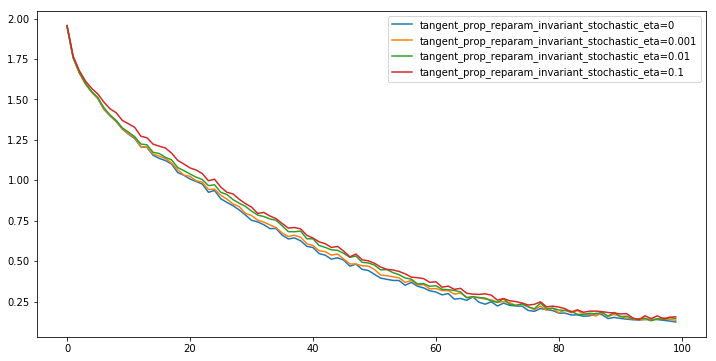

In [67]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_losses[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


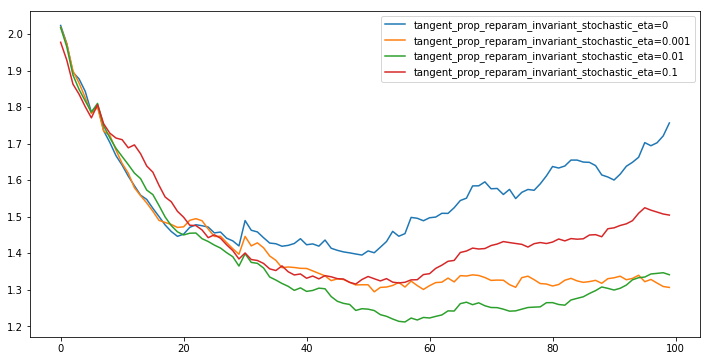

In [71]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(ewma(DataFrame(test_losses[mode]), alpha=0.1))
plt.legend(modes)

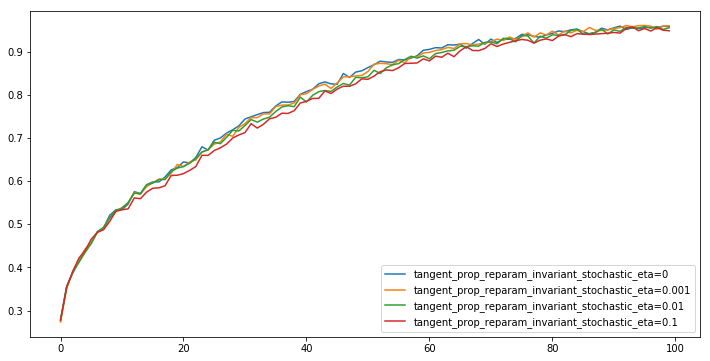

In [69]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_accs[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


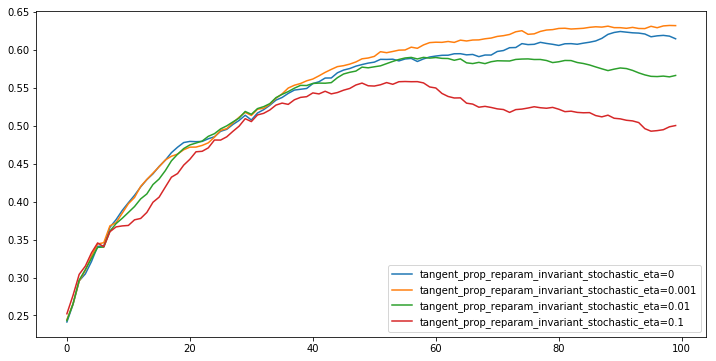

In [72]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(ewma(DataFrame(test_accs[mode]), alpha=0.1))
plt.legend(modes)